### Initialization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
from src.utils.simulator import batch_simulator
from scipy.stats import gaussian_kde
import torch
from os import cpu_count
from sbi import utils as utils
import divergences
from helper_functions import sample_from_posterior, build_theta_for_batch_simulator_from_samples_tensor, plot_angular_velocity
from matplotlib.lines import Line2D

In [2]:
f_ref = 50
n_workers = cpu_count() # Number of parallel workers for batch simulator

### Mallorca (ES_PM01 dataset)

In [3]:
## Processing 2019 ES_PM01 dataset
df = pd.read_csv("ES_PM01.csv", delimiter=";", usecols=["Time", "f50_ES_PM", "QI_ES_PM"])
# we will look at the angular velocity. note that f50_ES_PM is given in mHz
df["angular_velocity"] = 2 * np.pi * (df["f50_ES_PM"] / 1000)
dateandtime = pd.to_datetime(df["Time"])
df["date"] = dateandtime.dt.date
df["hour"] = dateandtime.dt.hour

# handling low quality data by masking all rows where there has been a time point with QI_ES_PM = 2 in the same hour
# additionally, use the datetime as index (allows us to access the data by time more easily)
df = df.merge(df[df["QI_ES_PM"] == 2][["date", "hour"]].drop_duplicates(), how="left", on=["date", "hour"], indicator=True)
df["DatetimeIndex"] = pd.DatetimeIndex(df["Time"])
df.set_index("DatetimeIndex", inplace=True)
df.mask((df["_merge"] == "both"), inplace=True)

# drop unnecessary and redundant columns
df.drop(columns=["Time", "_merge"], inplace=True)

#### Parameter Estimation with Fixed Inertia

##### General posterior (60min)

In [22]:
number_of_samples = 500
time_span = 3600
days = 90
hours = 24 # 24 hours in a day
dt = 1.0 # because the divergence plots take too long for dt=0.01

In [23]:
# load the posterior
in_s = open("out/posterior_NPE_3600s_dt" + str(dt) + ".pickle", "rb")
try:
    posterior_NPE = pickle.load(in_s)
finally:
    in_s.close()

In [24]:
# compute the data used for the daily parameter profiles. this includes the means and the 25th and 75th percentiles for each parameter and each hour of each day

start = datetime.datetime(2019, 10, 1, 0, 0, 0)

c1_means = np.zeros((days, hours))
c1_q25 = np.zeros((days, hours))
c1_q75 = np.zeros((days, hours))

c2_means = np.zeros((days, hours))
c2_q25 = np.zeros((days, hours))
c2_q75 = np.zeros((days, hours))

p0_means = np.zeros((days, hours))
p0_q25 = np.zeros((days, hours))
p0_q75 = np.zeros((days, hours))

p1_means = np.zeros((days, hours))
p1_q25 = np.zeros((days, hours))
p1_q75 = np.zeros((days, hours))

for j in range(0, days):
    day = start.day

    for i in range(0, hours):
        end = start + datetime.timedelta(minutes=59, seconds=59)

        # we take a 60-minute long observation
        x_obs = df[str(start):str(end)]["angular_velocity"].to_numpy()
        
        # print current day and hour for debugging
        # print("Day: " + str(day) + ", Hour: " + str(start.hour))

        # need to handle data that falls outside of the prior range of omega_0 or is NaN
        # in those cases, we will set the values to NaN and skip to the next hour
        if (x_obs.size == 0 or np.any(np.isnan(x_obs)) or x_obs[0] < -0.6 or x_obs[0] > 0.6):
            c1_means[j][i] = np.nan
            c1_q25[j][i] = np.nan
            c1_q75[j][i] = np.nan

            c2_means[j][i] = np.nan
            c2_q25[j][i] = np.nan
            c2_q75[j][i] = np.nan

            p0_means[j][i] = np.nan
            p0_q25[j][i] = np.nan
            p0_q75[j][i] = np.nan

            p1_means[j][i] = np.nan
            p1_q25[j][i] = np.nan
            p1_q75[j][i] = np.nan

            start = start + datetime.timedelta(minutes=60)
            continue
        
        samples_NPE = sample_from_posterior(posterior_NPE, number_of_samples, x_obs)

        c1_means[j][i] = samples_NPE[:, 2].mean().item()
        c1_q25[j][i] = np.quantile(samples_NPE[:, 2].numpy(), 0.25)
        c1_q75[j][i] = np.quantile(samples_NPE[:, 2].numpy(), 0.75)
        
        c2_means[j][i] = samples_NPE[:, 3].mean().item()
        c2_q25[j][i] = np.quantile(samples_NPE[:, 3].numpy(), 0.25)
        c2_q75[j][i] = np.quantile(samples_NPE[:, 3].numpy(), 0.75)

        p0_means[j][i] = samples_NPE[:, 4].mean().item()
        p0_q25[j][i] = np.quantile(samples_NPE[:, 4].numpy(), 0.25)
        p0_q75[j][i] = np.quantile(samples_NPE[:, 4].numpy(), 0.75)

        p1_means[j][i] = samples_NPE[:, 5].mean().item()
        p1_q25[j][i] = np.quantile(samples_NPE[:, 5].numpy(), 0.25)
        p1_q75[j][i] = np.quantile(samples_NPE[:, 5].numpy(), 0.75)

        start = start + datetime.timedelta(minutes=60)

Day: 1, Hour: 0
Day: 1, Hour: 1
Day: 1, Hour: 2
Day: 1, Hour: 3
Day: 1, Hour: 4
Day: 1, Hour: 5
Day: 1, Hour: 6
Day: 1, Hour: 7
Day: 1, Hour: 8
Day: 1, Hour: 9
Day: 1, Hour: 10
Day: 1, Hour: 11
Day: 1, Hour: 12
Day: 1, Hour: 13
Day: 1, Hour: 14
Day: 1, Hour: 15
Day: 1, Hour: 16
Day: 1, Hour: 17
Day: 1, Hour: 18
Day: 1, Hour: 19
Day: 1, Hour: 20
Day: 1, Hour: 21
Day: 1, Hour: 22
Day: 1, Hour: 23
Day: 2, Hour: 0
Day: 2, Hour: 1
Day: 2, Hour: 2
Day: 2, Hour: 3
Day: 2, Hour: 4
Day: 2, Hour: 5
Day: 2, Hour: 6
Day: 2, Hour: 7
Day: 2, Hour: 8
Day: 2, Hour: 9
Day: 2, Hour: 10
Day: 2, Hour: 11
Day: 2, Hour: 12
Day: 2, Hour: 13
Day: 2, Hour: 14
Day: 2, Hour: 15
Day: 2, Hour: 16
Day: 2, Hour: 17
Day: 2, Hour: 18
Day: 2, Hour: 19
Day: 2, Hour: 20
Day: 2, Hour: 21
Day: 2, Hour: 22
Day: 2, Hour: 23
Day: 3, Hour: 0
Day: 3, Hour: 1
Day: 3, Hour: 2
Day: 3, Hour: 3
Day: 3, Hour: 4
Day: 3, Hour: 5
Day: 3, Hour: 6
Day: 3, Hour: 7
Day: 3, Hour: 8
Day: 3, Hour: 9
Day: 3, Hour: 10
Day: 3, Hour: 11
Day: 3, Ho

In [32]:
print(f"share of NaNs in dataset is {np.isnan(df['angular_velocity']).mean()}")
print(f"share of skipped observations is {np.isnan(c1_means).mean()}")

share of NaNs in dataset is 0.06648936170212766
share of skipped observations is 0.24027777777777778


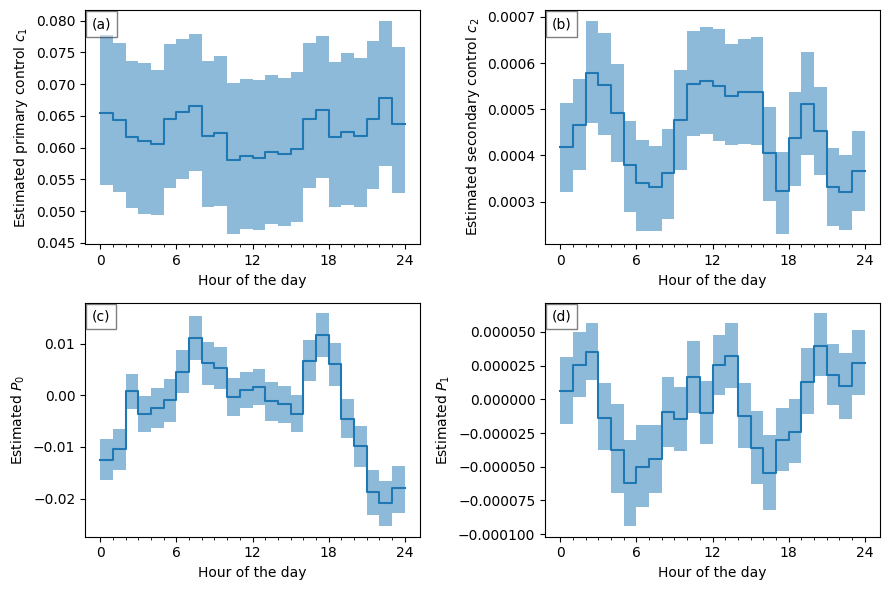

In [26]:
# generates the combined plot of parameter daily profiles of c_1, c_2, P_0, and P_1
# the highlighted area around the mean line represents the 25th and 75th percentiles
fig, axs = plt.subplots(2, 2, figsize=(9, 6))
x = np.arange(0, 24 + 1)

# set the x-axis ticks
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks([0, 6, 12, 18, 24])
        ax.set_xticks(np.arange(0, 25, 1), minor=True)
        ax.set_xlabel("Hour of the day")

# first subplot: daily profile of c_1
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(c1_means[:, i])
y[-1] = y[-2]
axs[0][0].plot(x, y, drawstyle="steps-post")
axs[0][0].fill_between(x, 
                       np.append(np.nanmean(c1_q25, axis=0), np.nanmean(c1_q25, axis=0)[-1]),
                        np.append(np.nanmean(c1_q75, axis=0), np.nanmean(c1_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[0][0].set_ylabel(r"Estimated primary control $c_1$")
axs[0][0].text(0.02, 0.97, "(a)", transform=axs[0][0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# second subplot: daily profile of c_2
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(c2_means[:, i])
y[-1] = y[-2]
axs[0][1].plot(x, y, drawstyle="steps-post")
axs[0][1].fill_between(x, 
                       np.append(np.nanmean(c2_q25, axis=0), np.nanmean(c2_q25, axis=0)[-1]), 
                       np.append(np.nanmean(c2_q75, axis=0), np.nanmean(c2_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[0][1].set_ylabel(r"Estimated secondary control $c_2$")
axs[0][1].text(0.02, 0.97, "(b)", transform=axs[0][1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# third subplot: daily profile of P_0
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(p0_means[:, i])
y[-1] = y[-2]
axs[1][0].plot(x, y, drawstyle="steps-post")
axs[1][0].fill_between(x, 
                       np.append(np.nanmean(p0_q25, axis=0), np.nanmean(p0_q25, axis=0)[-1]),
                       np.append(np.nanmean(p0_q75, axis=0), np.nanmean(p0_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[1][0].set_ylabel(r"Estimated $P_0$")
axs[1][0].text(0.02, 0.97, "(c)", transform=axs[1][0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# fourth subplot: daily profile of P_1
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(p1_means[:, i])
y[-1] = y[-2]
axs[1][1].plot(x, y, drawstyle="steps-post")
axs[1][1].fill_between(x, 
                       np.append(np.nanmean(p1_q25, axis=0), np.nanmean(p1_q25, axis=0)[-1]),
                       np.append(np.nanmean(p1_q75, axis=0), np.nanmean(p1_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[1][1].set_ylabel(r"Estimated $P_1$")
axs[1][1].text(0.02, 0.97, "(d)", transform=axs[1][1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

plt.tight_layout()
plt.savefig("figures/empirical_evaluation_ES_PM01_daily_profiles_60min.pdf", bbox_inches="tight", format="pdf")
plt.show()

#### Parameter Estimation with Constrained Frequency Control

In [4]:
dt = 0.01 # due to the much shorter interval length of 60s, a step size of dt=0.01 becomes possible again
number_of_samples = 500
days = 90
hours = 24 # only < 24 if days = 0

In [5]:
# read in the prior and posterior
in_s = open("out/prior_NPE_inertia_60s_dt0.01.pickle", "rb")
try:
    prior_inertia = pickle.load(in_s)
finally:
    in_s.close()

in_s = open("out/posterior_NPE_inertia_60s_dt0.01.pickle", "rb")
try:
    posterior_NPE_inertia = pickle.load(in_s)
finally:
    in_s.close()

In [6]:
# compute the data used for the daily parameter profiles. this includes the means and the 25th and 75th percentiles for each parameter and each hour of each day

start = datetime.datetime(2019, 10, 1, 0, 0, 0)

p0_means = np.zeros((days, hours))
p0_q25 = np.zeros((days, hours))
p0_q75 = np.zeros((days, hours))

p1_means = np.zeros((days, hours))
p1_q25 = np.zeros((days, hours))
p1_q75 = np.zeros((days, hours))

H_means = np.zeros((days, hours))
H_q25 = np.zeros((days, hours))
H_q75 = np.zeros((days, hours))

for j in range(0, days):
    day = start.day

    for i in range(0, hours):
        end = start + datetime.timedelta(seconds=59)

        # we take a 60-second long observation of the angular velocity
        x_obs = df[str(start):str(end)]["angular_velocity"].to_numpy()

        # need to handle data that falls outside of the prior range of omega_0 or is NaN
        # in those cases, we will set the values to NaN and skip to the next hour
        if (x_obs.size == 0 or np.any(np.isnan(x_obs)) or x_obs[0] < -0.6 or x_obs[0] > 0.6):
            p0_means[j][i] = np.nan
            p0_q25[j][i] = np.nan
            p0_q75[j][i] = np.nan

            p1_means[j][i] = np.nan
            p1_q25[j][i] = np.nan
            p1_q75[j][i] = np.nan

            H_means[j][i] = np.nan
            H_q25[j][i] = np.nan
            H_q75[j][i] = np.nan

            start = start + datetime.timedelta(hours=1)
            continue
        
        samples_NPE = sample_from_posterior(posterior_NPE_inertia, number_of_samples, x_obs)

        p0_means[j][i] = samples_NPE[:, 1].mean().item()
        p0_q25[j][i] = np.quantile(samples_NPE[:, 1].numpy(), 0.25)
        p0_q75[j][i] = np.quantile(samples_NPE[:, 1].numpy(), 0.75)

        p1_means[j][i] = samples_NPE[:, 2].mean().item()
        p1_q25[j][i] = np.quantile(samples_NPE[:, 2].numpy(), 0.25)
        p1_q75[j][i] = np.quantile(samples_NPE[:, 2].numpy(), 0.75)

        H_means[j][i] = samples_NPE[:, 4].mean().item()
        H_q25[j][i] = np.quantile(samples_NPE[:, 4].numpy(), 0.25)
        H_q75[j][i] = np.quantile(samples_NPE[:, 4].numpy(), 0.75)

        start = start + datetime.timedelta(hours=1)


In [7]:
print(f"share of NaNs in dataset is {np.isnan(df['angular_velocity']).mean()}")
print(f"share of skipped observations is {np.isnan(H_means).mean()}")

share of NaNs in dataset is 0.06648936170212766
share of skipped observations is 0.24027777777777778


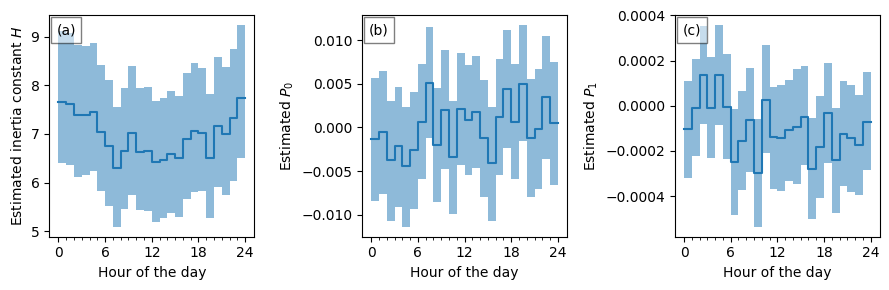

In [9]:
# generate the combined plot of parameter daily profiles
# the highlighted area around the mean line represents the 25th and 75th percentiles
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
x = np.arange(0, 24 + 1)

# set the x-axis ticks
for ax in axs:
    ax.set_xticks([0, 6, 12, 18, 24])
    ax.set_xticks(np.arange(0, 25, 1), minor=True)
    ax.set_xlabel("Hour of the day")

# first subplot: daily profile of H
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(H_means[:, i])
y[-1] = y[-2]
axs[0].plot(x, y, drawstyle="steps-post")
axs[0].fill_between(x, 
                    np.append(np.nanmean(H_q25, axis=0), np.nanmean(H_q25, axis=0)[-1]), 
                    np.append(np.nanmean(H_q75, axis=0), np.nanmean(H_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[0].set_ylabel(r"Estimated inertia constant $H$")
axs[0].text(0.035, 0.965, "(a)", transform=axs[0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# second subplot: daily profile of P_0
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(p0_means[:, i])
y[-1] = y[-2]
axs[1].plot(x, y, drawstyle="steps-post")
axs[1].fill_between(x, 
                    np.append(np.nanmean(p0_q25, axis=0), np.nanmean(p0_q25, axis=0)[-1]), 
                    np.append(np.nanmean(p0_q75, axis=0), np.nanmean(p0_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[1].set_ylabel(r"Estimated $P_0$")
axs[1].text(0.035, 0.965, "(b)", transform=axs[1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# third subplot: daily profile of P_1
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(p1_means[:, i])
y[-1] = y[-2]
axs[2].plot(x, y, drawstyle="steps-post")
axs[2].fill_between(x, 
                    np.append(np.nanmean(p1_q25, axis=0), np.nanmean(p1_q25, axis=0)[-1]),
                    np.append(np.nanmean(p1_q75, axis=0), np.nanmean(p1_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[2].set_ylabel(r"Estimated $P_1$")
axs[2].text(0.04, 0.965, "(c)", transform=axs[2].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

plt.tight_layout()
plt.savefig("figures/empirical_evaluation_ES_PM01_inertia_daily_profiles.pdf", bbox_inches="tight", format="pdf")
plt.show()

In [ ]:
# the divergence plot can be found in the external python-files due to the need for multiprocessing.

##### Empirical Power Mismatch (60min)

In [4]:
# settings

dt = 0.1
time_span = 3600
number_of_samples = 500
hours = 24
start = datetime.datetime(2019, 11, 6, 0, 0, 0) # specific observation date
end = start + datetime.timedelta(hours=hours)

In [5]:
# read in and preprocess the load and est. load data for the specific observation date

filename = "Custom-Report-2019-11-6-Seguimiento de la demanda de energía eléctrica (MW).csv"
columns = pd.read_csv(filename, encoding="latin", nrows=1).columns
df_load = pd.read_csv(filename, encoding="latin", usecols=columns)
# Align the time of the red electrica data (UTC+1) with the time of the angular velocity data from the power grid frequency database (UTC)
df_load.index = pd.to_datetime(df_load["Hora"]) - datetime.timedelta(hours=1)
df_load.index.name = "Time (UTC)"
df_load = df_load[str(start):str(end)]
df_load.drop(columns=["Hora"], inplace=True)

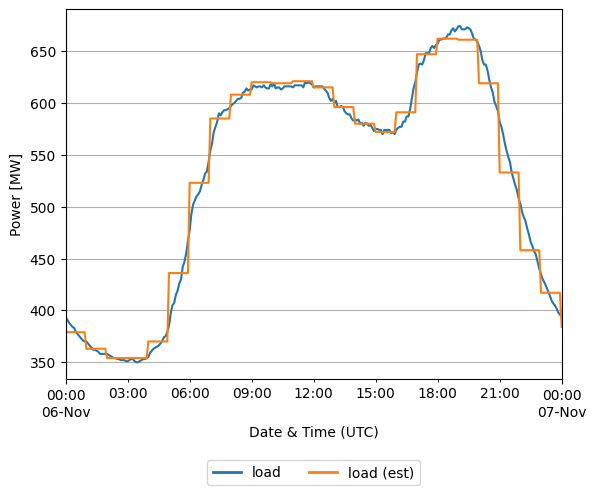

In [9]:
# plot the load and estimated load data for the specific observation date

df_load["Real"][str(start):str(end)].plot()
df_load["Programada"][str(start):str(end)].plot()
plt.xlabel("Date & Time (UTC)")
plt.ylabel("Power [MW]")
plt.grid()
legend_handles = [Line2D([0], [0], color="tab:blue", lw=2, label="load"),
                    Line2D([0], [0], color="tab:orange", lw=2, label="load (est)")]
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=2)
plt.savefig("figures/empirical_evaluation_ES_PM01_load_loadest_plot.pdf", bbox_inches="tight", format="pdf")
plt.show()

In [7]:
# compute the empirical mismatch
df_load["mismatch"] = df_load["Programada"] - df_load["Real"]

##### First plot (08:00 to 09:00)

In [8]:
start = datetime.datetime(2019, 11, 6, 8, 0, 0)
end = start + datetime.timedelta(minutes=59, seconds=59)
df_load[str(start):str(end)]

,Real,Prevista,Programada,mismatch
Time (UTC),,,,
2019-11-06 08:00:00,597.0,600,608,11.0
2019-11-06 08:05:00,599.0,602,608,9.0
2019-11-06 08:10:00,600.0,603,608,8.0
2019-11-06 08:15:00,602.0,604,608,6.0
2019-11-06 08:20:00,604.0,606,608,4.0
2019-11-06 08:25:00,604.0,607,608,4.0
2019-11-06 08:30:00,605.0,608,608,3.0
2019-11-06 08:35:00,610.0,609,608,-2.0
2019-11-06 08:40:00,611.0,611,608,-3.0


In [9]:
# compute the empirical P_0 and P_1 parameters for the specific observation from 2019-11-06 08:00:00 to 2019-11-06 09:00:00
df_subset = df_load[str(start):str(end)]
x = (df_subset.index - df_subset.index[0]).total_seconds()
y = df_subset["mismatch"].values

# Fit a first degree polynomial to the data
p_1_empirical, p_0_empirical = np.polyfit(x, y, 1)
print(f"Empirical P_0 = {p_0_empirical} [MW]")
print(f"Empirical P_1 = {p_1_empirical} [MW]")

p_0_empirical_rounded = round(p_0_empirical, 4)
p_1_empirical_rounded = round(p_1_empirical, 4)

Empirical P_0 = 10.833333333333325 [MW]
Empirical P_1 = -0.005303030303030302 [MW]


In [10]:
# one can use these values to train a specific posterior distribution via "python train.py --specific_observation P_0 P_1"

In [11]:
# read in the general posterior
in_s = open("out/posterior_NPE_3600s_dt0.1.pickle", "rb")
try:
    posterior_NPE = pickle.load(in_s)
finally:
    in_s.close()

In [12]:
# read in the specific posterior
in_s = open(f"out/posterior_NPE_specific_observation_3600s_dt0.1_p0{p_0_empirical_rounded}_p1{p_1_empirical_rounded}.pickle", "rb")
try:
    posterior_NPE_specific_observation = pickle.load(in_s)
finally:
    in_s.close()

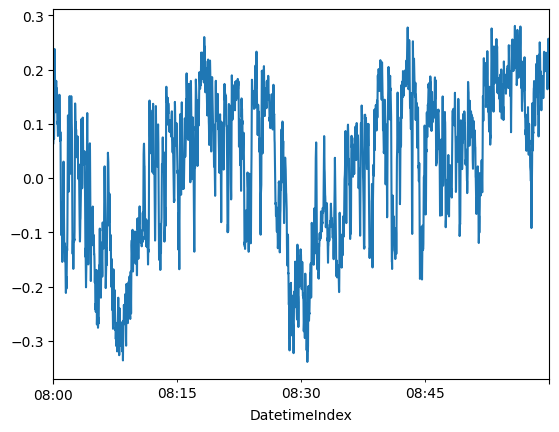

In [13]:
end = start + datetime.timedelta(minutes=59, seconds=59)
plot_angular_velocity(df, start, end)
x_obs = df[str(start):str(end)]["angular_velocity"].to_numpy()

In [14]:
# sample from the general posterior and generate the simulations.
samples_NPE = sample_from_posterior(posterior_NPE, number_of_samples, x_obs)
theta = build_theta_for_batch_simulator_from_samples_tensor(samples_NPE)
simulation_results_posterior_NPE = batch_simulator(theta, time_span, dt, n_workers)[1][:, ::int(1/dt)]
simulation_mean_parameters = batch_simulator(build_theta_for_batch_simulator_from_samples_tensor(samples_NPE.mean(dim=0).unsqueeze(0)), time_span, dt, n_workers)[1][0][::int(1/dt)]

In [15]:
# sample from the specific posterior and generate the simulations.
samples_NPE_specific = sample_from_posterior(posterior_NPE_specific_observation, number_of_samples, x_obs)
theta = build_theta_for_batch_simulator_from_samples_tensor(samples_NPE_specific, specific_observation=True, specific_P0=p_0_empirical_rounded, specific_P1=p_1_empirical_rounded)
simulation_results_specific_posterior_NPE = batch_simulator(theta, time_span, dt, n_workers)[1][:, ::int(1/dt)]
simulation_mean_parameters_specific = simulation_mean_parameters_specific = batch_simulator(build_theta_for_batch_simulator_from_samples_tensor(samples_NPE_specific.mean(dim=0).unsqueeze(0), specific_observation=True, specific_P0=p_0_empirical_rounded, specific_P1=p_1_empirical_rounded), time_span, dt, n_workers)[1][0][::int(1/dt)]

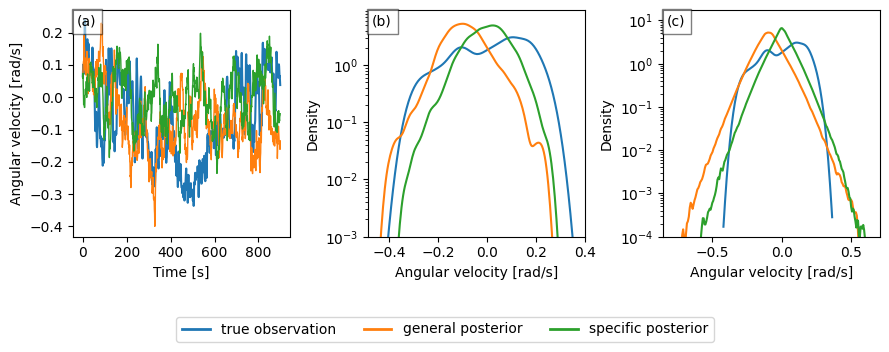

In [21]:
# generate the combined plot of parameter daily profiles
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# first subplot: simulations of the mean predicted parameters
axs[0].plot(x_obs[0:900])
axs[0].plot(simulation_mean_parameters[0:900], linewidth=1)
axs[0].plot(simulation_mean_parameters_specific[0:900], linewidth=1)
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Angular velocity [rad/s]")
axs[0].text(0.02, 0.98, "(a)", transform=axs[0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# second subplot: kernel density estimation of the simulations of the mean predicted parameters
sns.kdeplot(x_obs, label="True observation", ax=axs[1])
sns.kdeplot(simulation_mean_parameters, label="Simulation of mean predicted parameters", ax=axs[1])
sns.kdeplot(simulation_mean_parameters_specific, label="Simulation of mean predicted parameters with specific posterior", ax=axs[1])
axs[1].set_yscale("log")
axs[1].set_ylim(bottom=1e-3)
axs[1].set_xlabel("Angular velocity [rad/s]")
axs[1].text(0.02, 0.98, "(b)", transform=axs[1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# third subplot: kernel density estimations of the simulations for all predicted parameters
sns.kdeplot(x_obs, label="True observation", ax=axs[2])
sns.kdeplot(simulation_results_posterior_NPE.flatten(), label="Simulation results of general posterior", ax=axs[2])
sns.kdeplot(simulation_results_specific_posterior_NPE.flatten(), label="Simulation results of specific posterior", ax=axs[2])
axs[2].set_yscale("log")
axs[2].set_ylim(bottom=1e-4)
axs[2].set_xlabel("Angular velocity [rad/s]")
axs[2].text(0.02, 0.98, "(c)", transform=axs[2].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# legend settings
legend_handles = [Line2D([0], [0], color="tab:blue", lw=2, label="true observation"),
                    Line2D([0], [0], color="tab:orange", lw=2, label="general posterior"),
                    Line2D([0], [0], color="tab:green", lw=2, label="specific posterior")]
fig.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.tight_layout()
plt.savefig("figures/empirical_evaluation_Mallorca_specific_observation_1.pdf", bbox_inches="tight", format="pdf")
plt.show()

In [22]:
# compute the mean Jensen-Shannon divergence between the true observation and the simulations of the general posterior samples
js_div_general = np.nanmean([divergences.jensen_shannon_div(gaussian_kde(x_obs), gaussian_kde(simulation)) for simulation in simulation_results_posterior_NPE])
print(f"Jensen-Shannon divergence between observation and simulations of general posterior samples is {js_div_general}")

Jensen-Shannon divergence between observation and simulations of general posterior samples is 0.1946299456873457


In [23]:
# compute the mean Jensen-Shannon divergence between the true observation and the simulations of the specific posterior samples
js_div_specific = np.nanmean([divergences.jensen_shannon_div(gaussian_kde(x_obs), gaussian_kde(simulation)) for simulation in simulation_results_specific_posterior_NPE])
print(f"Jensen-Shannon divergence between observation and simulations of specific posterior samples is {js_div_specific}")

Jensen-Shannon divergence between observation and simulations of specific posterior samples is 0.14711203084048952


##### Second plot (09:00 to 10:00)

In [24]:
start = datetime.datetime(2019, 11, 6, 9, 0, 0)
end = start + datetime.timedelta(minutes=59, seconds=59)

In [25]:
# compute the empirical P_0 and P_1 parameters for the specific observation from 2019-11-06 09:00:00 to 2019-11-06 10:00:00
df_subset = df_load[str(start):str(end)]
x = (df_subset.index - df_subset.index[0]).total_seconds()
y = df_subset["mismatch"].values

# Fit a first degree polynomial to the data
p_1_empirical, p_0_empirical = np.polyfit(x, y, 1)
print(f"Empirical P_0 = {p_0_empirical} [MW]")
print(f"Empirical P_1 = {p_1_empirical} [MW]")

p_0_empirical_rounded = round(p_0_empirical, 4)
p_1_empirical_rounded = round(p_1_empirical, 4)

Empirical P_0 = 4.807692307692307 [MW]
Empirical P_1 = -0.00018648018648018597 [MW]


In [26]:
# read in the specific posterior
in_s = open(f"out/posterior_NPE_specific_observation_3600s_dt0.1_p0{p_0_empirical_rounded}_p1{p_1_empirical_rounded}.pickle", "rb")
try:
    posterior_NPE_specific_observation = pickle.load(in_s)
finally:
    in_s.close()

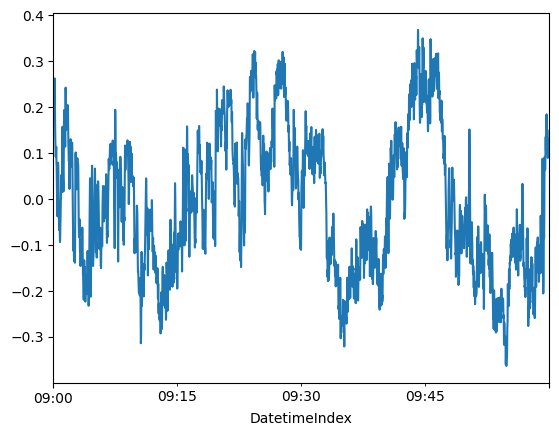

In [27]:
end = start + datetime.timedelta(minutes=59, seconds=59)
plot_angular_velocity(df, start, end)
x_obs = df[str(start):str(end)]["angular_velocity"].to_numpy()

In [28]:
# sample from the general posterior and generate the simulations.
samples_NPE = sample_from_posterior(posterior_NPE, number_of_samples, x_obs)
theta = build_theta_for_batch_simulator_from_samples_tensor(samples_NPE)
simulation_results_posterior_NPE = batch_simulator(theta, time_span, dt, n_workers)[1][:, ::int(1/dt)]
simulation_mean_parameters = batch_simulator(build_theta_for_batch_simulator_from_samples_tensor(samples_NPE.mean(dim=0).unsqueeze(0)), time_span, dt, n_workers)[1][0][::int(1/dt)]

In [29]:
# sample from the specific posterior and generate the simulations.
samples_NPE_specific = sample_from_posterior(posterior_NPE_specific_observation, number_of_samples, x_obs)
theta = build_theta_for_batch_simulator_from_samples_tensor(samples_NPE_specific, specific_observation=True, specific_P0=p_0_empirical_rounded, specific_P1=p_1_empirical_rounded)
simulation_results_specific_posterior_NPE = batch_simulator(theta, time_span, dt, n_workers)[1][:, ::int(1/dt)]
simulation_mean_parameters_specific = simulation_mean_parameters_specific = batch_simulator(build_theta_for_batch_simulator_from_samples_tensor(samples_NPE_specific.mean(dim=0).unsqueeze(0), specific_observation=True, specific_P0=p_0_empirical_rounded, specific_P1=p_1_empirical_rounded), time_span, dt, n_workers)[1][0][::int(1/dt)]

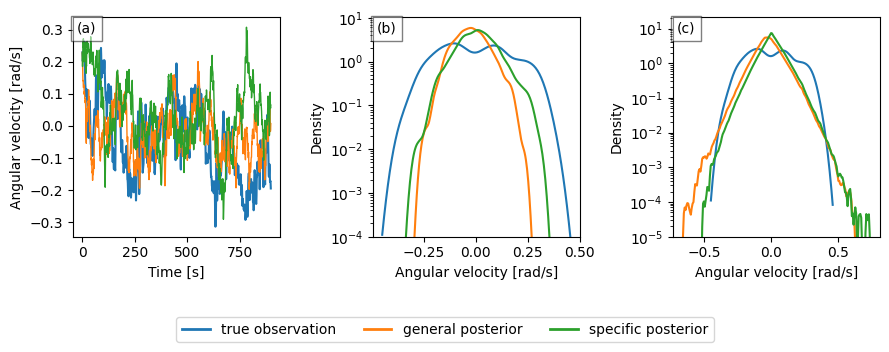

In [31]:
# combined plot of parameter daily profiles
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# first subplot: simulations of the mean predicted parameters
axs[0].plot(x_obs[0:900])
axs[0].plot(simulation_mean_parameters[0:900], linewidth=1)
axs[0].plot(simulation_mean_parameters_specific[0:900], linewidth=1)
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Angular velocity [rad/s]")
axs[0].text(0.02, 0.98, "(a)", transform=axs[0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# second subplot: kernel density estimation of the simulations of the mean predicted parameters
sns.kdeplot(x_obs, label="True observation", ax=axs[1])
sns.kdeplot(simulation_mean_parameters, label="Simulation of mean predicted parameters", ax=axs[1])
sns.kdeplot(simulation_mean_parameters_specific, label="Simulation of mean predicted parameters with specific posterior", ax=axs[1])
axs[1].set_yscale("log")
axs[1].set_ylim(bottom=1e-4)
axs[1].set_xlabel("Angular velocity [rad/s]")
axs[1].text(0.02, 0.98, "(b)", transform=axs[1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# third subplot: kernel density estimations of the simulations for all predicted parameters
sns.kdeplot(x_obs, label="True observation", ax=axs[2])
sns.kdeplot(simulation_results_posterior_NPE.flatten(), label="Simulation results of general posterior", ax=axs[2])
sns.kdeplot(simulation_results_specific_posterior_NPE.flatten(), label="Simulation results of specific posterior", ax=axs[2])
axs[2].set_yscale("log")
axs[2].set_ylim(bottom=1e-5)
axs[2].set_xlabel("Angular velocity [rad/s]")
axs[2].text(0.02, 0.98, "(c)", transform=axs[2].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# legend settings
legend_handles = [Line2D([0], [0], color="tab:blue", lw=2, label="true observation"),
                    Line2D([0], [0], color="tab:orange", lw=2, label="general posterior"),
                    Line2D([0], [0], color="tab:green", lw=2, label="specific posterior")]
fig.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.tight_layout()
plt.savefig("figures/empirical_evaluation_Mallorca_specific_observation_2.pdf", bbox_inches="tight", format="pdf")
plt.show()

In [32]:
# compute the mean Jensen-Shannon divergence between the true observation and the simulations of the general posterior samples
js_div_general_2 = np.nanmean([divergences.jensen_shannon_div(gaussian_kde(x_obs), gaussian_kde(simulation)) for simulation in simulation_results_posterior_NPE])
print(f"Jensen-Shannon divergence between observation and simulations of general posterior samples is {js_div_general_2}")

Jensen-Shannon divergence between observation and simulations of general posterior samples is 0.16737577269789367


In [33]:
# compute the mean Jensen-Shannon divergence between the true observation and the simulations of the specific posterior samples
js_div_specific_2 = np.nanmean([divergences.jensen_shannon_div(gaussian_kde(x_obs), gaussian_kde(simulation)) for simulation in simulation_results_specific_posterior_NPE])
print(f"Jensen-Shannon divergence between observation and simulations of specific posterior samples is {js_div_specific_2}")

Jensen-Shannon divergence between observation and simulations of specific posterior samples is 0.15691943134412897


##### Compare predicted and empirical power mismatch values below

In [17]:
### compare predicted P0, P1 values of general posterior to empirical values
print(f"Predicted P_0 is {samples_NPE[:, 4].mean().item() * samples_NPE[:, 6].mean().item()}")
print(f"Predicted P_1 is {samples_NPE[:, 5].mean().item() * samples_NPE[:, 6].mean().item()}")

Predicted P_0 is 0.0002744147922692161
Predicted P_1 is -2.0460544400994964e-06


In [24]:
print(f"predicted ratio is {samples_NPE[:, 4].mean().item() / (samples_NPE[:, 5].mean().item())}")
print(f"empirical ratio is {p_0_empirical / p_1_empirical}")

predicted ratio is -134.11900821948402
empirical ratio is -2042.8571428571418
